## Install Libraries

In [ ]:
!pip install --upgrade pydataset --quiet
!pip install --upgrade catboost --quiet
!pip install --upgrade pingouin --quiet

     |████████████████████████████████| 15.9 MB 4.8 MB/s 
     |████████████████████████████████| 76.3 MB 107 kB/s 
     |████████████████████████████████| 182 kB 5.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 9.8 MB 51.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Import Libraries

In [ ]:
import pydataset
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool, cv

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import pingouin

## Set config

In [ ]:
class Config:
    N_SPLITS = 5
    # LEARNING_RATE = .1
    SEED = 8001

## Load dataset

In [ ]:
X = pydataset.data('rwm5yr')
y = (X['hospvis'] > 1).astype(int)
X = X.drop('hospvis', axis=1)

X.shape

(19609, 16)

### Split train and valid

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=.2, 
    stratify=y, 
    random_state=Config.SEED
    )

In [ ]:
kfold = StratifiedKFold(
    n_splits=Config.N_SPLITS,
    shuffle=True,
    random_state=Config.SEED
)

cv = list(kfold.split(X_train, y_train))

## Fundamental Analysis

### Train Model

In [439]:
clf_list = []

fimpo = pd.DataFrame(columns=X.columns)
roc_auc_scores = pd.DataFrame(index=['roc_auc train', 'roc_auc test'])

train_shap = pd.DataFrame(data=np.zeros_like(X_train), index=X_train.index, columns=X_train.columns)
oof_shap = pd.DataFrame(data=np.zeros_like(X_train), index=X_train.index, columns=X_test.columns)

test_shap = pd.DataFrame(data=np.zeros_like(X_test), index=X_test.index, columns=X_test.columns)

for i, (train_idx, valid_idx) in tqdm(enumerate(cv), total=Config.N_SPLITS):
    X_train_, X_valid_ = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_train_, y_valid_ = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    clf = CatBoostClassifier(
        random_seed=Config.SEED
        )

    clf.fit(
        X=X_train_,
        y=y_train_,
        eval_set=[(X_valid_, y_valid_)],
        early_stopping_rounds=100,
        verbose_eval=100, 
        )
    
    clf_list.append(clf)

    roc_auc_scores.loc['roc_auc train', i] = roc_auc_score(y_train_, clf.predict_proba(X_train_)[:, 1])
    roc_auc_scores.loc['roc_auc test', i] = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    fimpo.loc[i] = clf.get_feature_importance()

    X_train_shap_ = pd.DataFrame(
        data=clf.get_feature_importance(
            data=Pool(X_train_),
            type='ShapValues'
        )[:, :-1],
        index=X_train_.index,
        columns=X_train_.columns
    )
    train_shap = train_shap.add(X_train_shap_ / Config.N_SPLITS, fill_value=0)

    X_valid_shap_ = pd.DataFrame(
        data=clf.get_feature_importance(
            data=Pool(X_valid_),
            type='ShapValues'
        )[:, :-1],
        index=X_valid_.index,
        columns=X_valid_.columns
    )
    oof_shap = oof_shap.add(X_valid_shap_, fill_value=0)

    X_test_shap_ = pd.DataFrame(
        data=clf.get_feature_importance(
            data=Pool(X_test),
            type='ShapValues'
        )[:, :-1],
        index=X_test.index,
        columns=X_test.columns
    )
    test_shap = test_shap.add(X_test_shap_, fill_value=0)

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5813215	test: 0.5819588	best: 0.5819588 (0)	total: 4.45ms	remaining: 4.44s
100:	learn: 0.0646011	test: 0.0825543	best: 0.0824621 (95)	total: 446ms	remaining: 3.97s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08246213939
bestIteration = 95

Shrink model to first 96 iterations.
Learning rate set to 0.059192
0:	learn: 0.5809362	test: 0.5810274	best: 0.5810274 (0)	total: 4.66ms	remaining: 4.65s
100:	learn: 0.0644766	test: 0.0819403	best: 0.0819080 (98)	total: 427ms	remaining: 3.8s
200:	learn: 0.0544219	test: 0.0827607	best: 0.0815523 (130)	total: 864ms	remaining: 3.43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08155228666
bestIteration = 130

Shrink model to first 131 iterations.
Learning rate set to 0.059194
0:	learn: 0.5819869	test: 0.5820395	best: 0.5820395 (0)	total: 5.18ms	remaining: 5.17s
100:	learn: 0.0655831	test: 0.0768478	best: 0.0767773 (83)	total: 423ms	remaining: 3.77s
Stopped by over

### Feature Importances

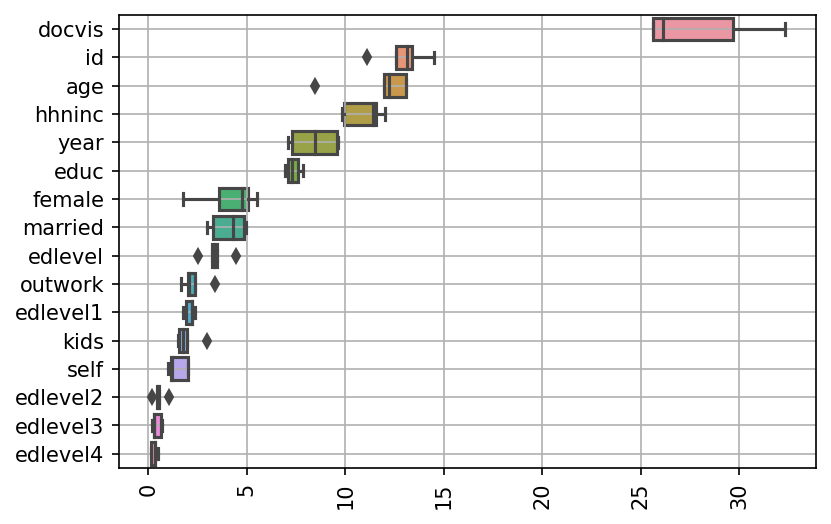

In [ ]:
fimpo_ = fimpo[fimpo.mean(0).sort_values(ascending=False).index]

plt.figure(dpi=150)
sns.boxplot(data=fimpo_, orient="h")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### ROC Score

In [ ]:
roc_auc_scores

,0,1,2,3,4
roc_auc train,0.885918,0.902818,0.872992,0.863542,0.882196
roc_auc test,0.791130,0.776226,0.798090,0.785177,0.769197


## Adversarial Validation

In [ ]:
fimpo_ad = pd.DataFrame(columns=X.columns)

for i, (train_idx, valid_idx) in tqdm(enumerate(cv), total=Config.N_SPLITS):
    X_train_, X_valid_ = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_train_, y_valid_ = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    X_ = pd.concat([X_train_, X_test], axis=0)

    y_ = pd.Series(
        data=[0] * len(X_train_) + [1] * len(X_test), 
        index=X_.index,
        name='is_test'
        )

    clf = CatBoostClassifier(
        n_estimators=1_000,
        random_seed=Config.SEED
        )

    clf.fit(
        X=X_,
        y=y_,
        eval_set=[(
            pd.concat([X_train_, X_valid_], axis=0), 
            pd.Series(
                data=[0] * len(X_train_) + [1] * len(X_valid_), 
                index=pd.concat([X_train_, X_valid_], axis=0).index,
                name='is_valid'
                )
            )],
        early_stopping_rounds=20,
        verbose_eval=100, 
        )

    fimpo_ad.loc[i] = clf.get_feature_importance()

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.063305
0:	learn: 0.6743784	test: 0.6716430	best: 0.6716430 (0)	total: 4.6ms	remaining: 4.6s
100:	learn: 0.5343673	test: 0.5016789	best: 0.5016433 (98)	total: 497ms	remaining: 4.42s
200:	learn: 0.5197034	test: 0.4990642	best: 0.4990570 (199)	total: 986ms	remaining: 3.92s
300:	learn: 0.5051092	test: 0.4964787	best: 0.4964787 (300)	total: 1.47s	remaining: 3.41s
400:	learn: 0.4917990	test: 0.4947197	best: 0.4947012 (398)	total: 1.96s	remaining: 2.93s
500:	learn: 0.4803141	test: 0.4931099	best: 0.4931099 (500)	total: 2.44s	remaining: 2.43s
600:	learn: 0.4690842	test: 0.4918870	best: 0.4918870 (600)	total: 2.94s	remaining: 1.95s
700:	learn: 0.4586806	test: 0.4903977	best: 0.4903977 (700)	total: 3.43s	remaining: 1.46s
800:	learn: 0.4490450	test: 0.4892343	best: 0.4892343 (800)	total: 3.91s	remaining: 972ms
900:	learn: 0.4404394	test: 0.4885574	best: 0.4885423 (899)	total: 4.39s	remaining: 482ms
999:	learn: 0.4319830	test: 0.4878262	best: 0.4878213 (997)	total: 4.87s	rem

### Feature Importance

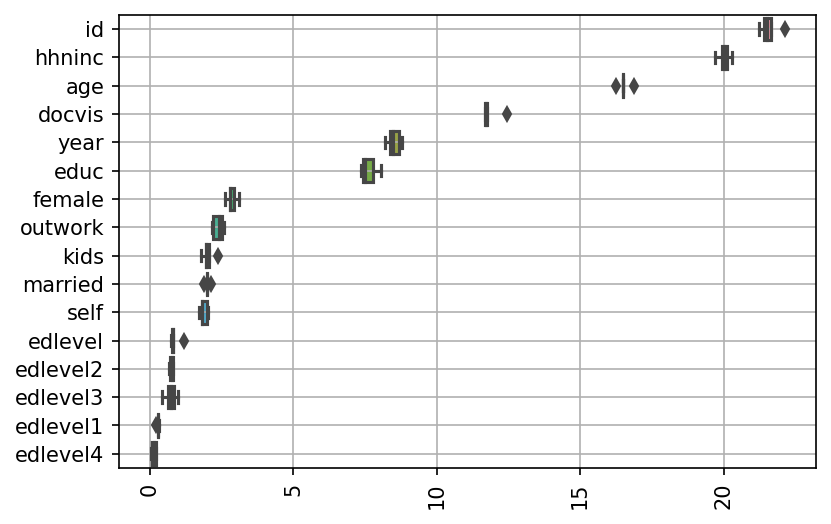

In [ ]:
fimpo_ad_ = fimpo_ad[fimpo_ad.mean(0).sort_values(ascending=False).index]

plt.figure(dpi=150)
sns.boxplot(data=fimpo_ad_, orient="h")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### Feature Selection

In [ ]:
# Feature selection
n_drop_max = 8

features_drop = fimpo_ad_.mean(0).sort_values(ascending=False).head(n_drop_max).index.to_list()
roc_auc_scores = {'train': pd.DataFrame(), 'test': pd.DataFrame()}

for n_drop in range(n_drop_max + 1):
    X_train_drop = X_train.drop(features_drop[:n_drop], axis = 1)

    for fold, (train_idx, valid_idx) in tqdm(enumerate(cv), total=Config.N_SPLITS):
        X_train_, X_valid_ = X_train_drop.iloc[train_idx], X_train_drop.iloc[valid_idx]
        y_train_, y_valid_ = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        clf = CatBoostClassifier(
            random_seed=Config.SEED
            )

        clf.fit(
            X=X_train_,
            y=y_train_,
            eval_set=[(X_valid_, y_valid_)],
            early_stopping_rounds=20,
            verbose_eval=100, 
            )

        roc_auc_scores['train'].loc[n_drop, fold] = roc_auc_score(y_train_, clf.predict_proba(X_train_)[:, 1])
        roc_auc_scores['test'].loc[n_drop, fold] = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5817676	test: 0.5819819	best: 0.5819819 (0)	total: 4.6ms	remaining: 4.59s
100:	learn: 0.0652907	test: 0.0768988	best: 0.0764702 (83)	total: 431ms	remaining: 3.84s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.07647016756
bestIteration = 83

Shrink model to first 84 iterations.
Learning rate set to 0.059192
0:	learn: 0.5808333	test: 0.5806488	best: 0.5806488 (0)	total: 4.43ms	remaining: 4.43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.07723022273
bestIteration = 76

Shrink model to first 77 iterations.
Learning rate set to 0.059194
0:	learn: 0.5804254	test: 0.5808325	best: 0.5808325 (0)	total: 4.37ms	remaining: 4.37s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08015471813
bestIteration = 69

Shrink model to first 70 iterations.
Learning rate set to 0.059194
0:	learn: 0.5804602	test: 0.5813125	best: 0.5813125 (0)	total: 4.45ms	remaining: 4.45s
Stopped by overfitting detector  

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5832774	test: 0.5832579	best: 0.5832579 (0)	total: 4.58ms	remaining: 4.57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.07745284978
bestIteration = 62

Shrink model to first 63 iterations.
Learning rate set to 0.059192
0:	learn: 0.5832681	test: 0.5835369	best: 0.5835369 (0)	total: 4.12ms	remaining: 4.12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.0784756685
bestIteration = 76

Shrink model to first 77 iterations.
Learning rate set to 0.059194
0:	learn: 0.5828800	test: 0.5834823	best: 0.5834823 (0)	total: 4.46ms	remaining: 4.46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08081563997
bestIteration = 61

Shrink model to first 62 iterations.
Learning rate set to 0.059194
0:	learn: 0.5836510	test: 0.5837072	best: 0.5837072 (0)	total: 4.01ms	remaining: 4.01s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08035425347
bestIteration = 51

Shrink model to first 

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5833798	test: 0.5834759	best: 0.5834759 (0)	total: 6.46ms	remaining: 6.45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.07792001118
bestIteration = 72

Shrink model to first 73 iterations.
Learning rate set to 0.059192
0:	learn: 0.5826536	test: 0.5830618	best: 0.5830618 (0)	total: 4.2ms	remaining: 4.19s
100:	learn: 0.0690784	test: 0.0777548	best: 0.0777094 (93)	total: 393ms	remaining: 3.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.07767573334
bestIteration = 105

Shrink model to first 106 iterations.
Learning rate set to 0.059194
0:	learn: 0.5830662	test: 0.5835720	best: 0.5835720 (0)	total: 3.94ms	remaining: 3.94s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08005453435
bestIteration = 48

Shrink model to first 49 iterations.
Learning rate set to 0.059194
0:	learn: 0.5833865	test: 0.5836189	best: 0.5836189 (0)	total: 3.85ms	remaining: 3.84s
Stopped by overfitting detector 

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5841725	test: 0.5843562	best: 0.5843562 (0)	total: 3.18ms	remaining: 3.17s
100:	learn: 0.0712786	test: 0.0783998	best: 0.0778866 (83)	total: 384ms	remaining: 3.42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.07788663733
bestIteration = 83

Shrink model to first 84 iterations.
Learning rate set to 0.059192
0:	learn: 0.5838832	test: 0.5841701	best: 0.5841701 (0)	total: 2.86ms	remaining: 2.86s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.07862776064
bestIteration = 77

Shrink model to first 78 iterations.
Learning rate set to 0.059194
0:	learn: 0.5842465	test: 0.5843319	best: 0.5843319 (0)	total: 2.53ms	remaining: 2.53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08050536926
bestIteration = 59

Shrink model to first 60 iterations.
Learning rate set to 0.059194
0:	learn: 0.5839815	test: 0.5840628	best: 0.5840628 (0)	total: 2.42ms	remaining: 2.42s
Stopped by overfitting detector 

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5845173	test: 0.5844889	best: 0.5844889 (0)	total: 5.99ms	remaining: 5.98s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.0874353005
bestIteration = 50

Shrink model to first 51 iterations.
Learning rate set to 0.059192
0:	learn: 0.5843502	test: 0.5845764	best: 0.5845764 (0)	total: 2.26ms	remaining: 2.26s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08773346891
bestIteration = 75

Shrink model to first 76 iterations.
Learning rate set to 0.059194
0:	learn: 0.5843869	test: 0.5845209	best: 0.5845209 (0)	total: 2.06ms	remaining: 2.06s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08692948569
bestIteration = 74

Shrink model to first 75 iterations.
Learning rate set to 0.059194
0:	learn: 0.5843249	test: 0.5844058	best: 0.5844058 (0)	total: 2.35ms	remaining: 2.35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08707192725
bestIteration = 55

Shrink model to first 

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5830720	test: 0.5834080	best: 0.5834080 (0)	total: 5.49ms	remaining: 5.49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08720444518
bestIteration = 70

Shrink model to first 71 iterations.
Learning rate set to 0.059192
0:	learn: 0.5830462	test: 0.5832754	best: 0.5832754 (0)	total: 4.52ms	remaining: 4.52s
100:	learn: 0.0839609	test: 0.0869217	best: 0.0869217 (100)	total: 321ms	remaining: 2.85s
200:	learn: 0.0821781	test: 0.0861220	best: 0.0861220 (200)	total: 669ms	remaining: 2.66s
300:	learn: 0.0811200	test: 0.0852917	best: 0.0852917 (300)	total: 1.07s	remaining: 2.48s
400:	learn: 0.0804760	test: 0.0847903	best: 0.0847903 (400)	total: 1.46s	remaining: 2.18s
500:	learn: 0.0801379	test: 0.0845319	best: 0.0845319 (500)	total: 1.86s	remaining: 1.85s
600:	learn: 0.0799728	test: 0.0844059	best: 0.0843970 (589)	total: 2.25s	remaining: 1.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08438443699
bestIterat

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5841817	test: 0.5844113	best: 0.5844113 (0)	total: 2.54ms	remaining: 2.53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08699872217
bestIteration = 64

Shrink model to first 65 iterations.
Learning rate set to 0.059192
0:	learn: 0.5839188	test: 0.5841929	best: 0.5841929 (0)	total: 2.87ms	remaining: 2.87s
100:	learn: 0.0850071	test: 0.0879314	best: 0.0878731 (91)	total: 275ms	remaining: 2.44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08787311856
bestIteration = 91

Shrink model to first 92 iterations.
Learning rate set to 0.059194
0:	learn: 0.5843200	test: 0.5843615	best: 0.5843615 (0)	total: 2.67ms	remaining: 2.67s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08655846975
bestIteration = 77

Shrink model to first 78 iterations.
Learning rate set to 0.059194
0:	learn: 0.5840486	test: 0.5841176	best: 0.5841176 (0)	total: 2.48ms	remaining: 2.48s
Stopped by overfitting detector 

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5839055	test: 0.5840480	best: 0.5840480 (0)	total: 3.48ms	remaining: 3.48s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08713701958
bestIteration = 61

Shrink model to first 62 iterations.
Learning rate set to 0.059192
0:	learn: 0.5839095	test: 0.5841563	best: 0.5841563 (0)	total: 7.68ms	remaining: 7.67s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08827065757
bestIteration = 57

Shrink model to first 58 iterations.
Learning rate set to 0.059194
0:	learn: 0.5842937	test: 0.5843168	best: 0.5843168 (0)	total: 2.68ms	remaining: 2.67s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08684446492
bestIteration = 59

Shrink model to first 60 iterations.
Learning rate set to 0.059194
0:	learn: 0.5840465	test: 0.5841897	best: 0.5841897 (0)	total: 2.56ms	remaining: 2.56s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08705307765
bestIteration = 67

Shrink model to first

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5840604	test: 0.5843800	best: 0.5843800 (0)	total: 2.32ms	remaining: 2.32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.0870607384
bestIteration = 63

Shrink model to first 64 iterations.
Learning rate set to 0.059192
0:	learn: 0.5837875	test: 0.5840608	best: 0.5840608 (0)	total: 2.36ms	remaining: 2.36s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08842063642
bestIteration = 59

Shrink model to first 60 iterations.
Learning rate set to 0.059194
0:	learn: 0.5841499	test: 0.5843248	best: 0.5843248 (0)	total: 2.77ms	remaining: 2.76s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08697862269
bestIteration = 72

Shrink model to first 73 iterations.
Learning rate set to 0.059194
0:	learn: 0.5840711	test: 0.5841461	best: 0.5841461 (0)	total: 2.7ms	remaining: 2.69s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08684511601
bestIteration = 61

Shrink model to first 6

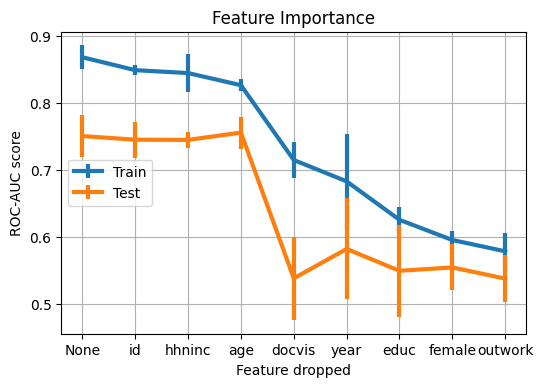

In [ ]:
# Plot feature selection
fig, ax = plt.subplots(dpi=100)
plt.subplots_adjust(wspace = .1)

ax.errorbar(
    x=roc_auc_scores['train'].index, 
    y=roc_auc_scores['train'].mean(axis = 1), 
    yerr=roc_auc_scores['train'].max(1) - roc_auc_scores['train'].min(1),
    lw = 3, 
    label = 'Train'
    )


ax.errorbar(
    x=roc_auc_scores['test'].index, 
    y=roc_auc_scores['test'].mean(axis = 1), 
    yerr=roc_auc_scores['test'].max(1) - roc_auc_scores['test'].min(1),
    lw = 3, 
    label = 'Test'
    )

ax.set(
    title='Feature Importance',
    xlabel='Feature dropped',
    ylabel='ROC-AUC score',
    xticks=roc_auc_scores['train'].index,
    xticklabels=['None'] + features_drop,
)

ax.grid(True)
ax.legend(loc='center left')

fig.show()

## Shap Values

In [440]:
def partial_correlation(X_shap: pd.DataFrame, y_true: pd.Series) -> pd.Series:
    output_series = pd.Series(
        index=X_shap.columns, 
        dtype=float
        )

    for col_name in X_shap.columns:
        partial_corr_value = pingouin.partial_corr(
            data= pd.concat([X_shap, y_true], axis=1).astype(float),
            x=col_name,
            y=y_true.name,
            x_covar=[feature_name for feature_name in X_shap.columns if feature_name != col_name]
        ).loc['pearson', 'r']

        output_series[col_name] = partial_corr_value

    return output_series

parshap_train = partial_correlation(train_shap, y_train)
parshap_test = partial_correlation(oof_shap, y_train)
# parshap_test = partial_correlation(test_shap, y_test)

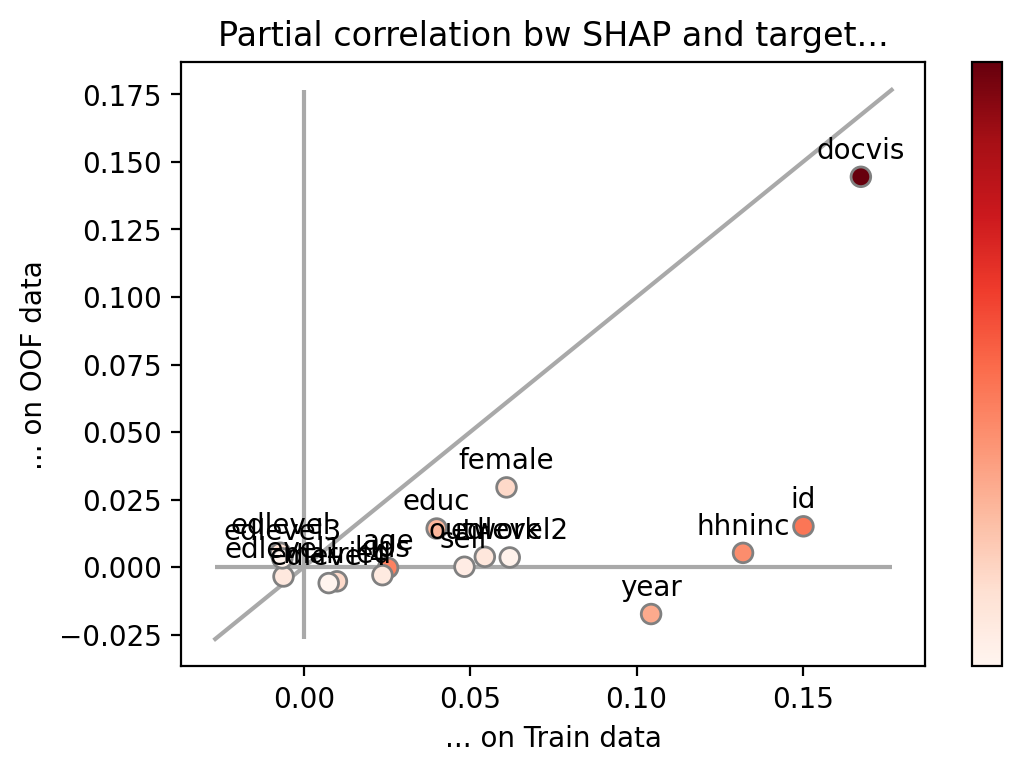

In [444]:
plotmin =  min(parshap_train.min(), parshap_test.min())
plotmax = max(parshap_train.max(), parshap_test.max())
plotbuffer = .05 * (plotmax - plotmin)

fig, ax = plt.subplots(dpi=200)

if plotmin < 0:
    ax.vlines(0, plotmin - plotbuffer, plotmax + plotbuffer, color = 'darkgrey', zorder = 0)
    ax.hlines(0, plotmin - plotbuffer, plotmax + plotbuffer, color = 'darkgrey', zorder = 0)

ax.plot(
    [plotmin - plotbuffer, plotmax + plotbuffer], [plotmin - plotbuffer, plotmax + plotbuffer], 
    color = 'darkgrey', zorder = 0
)

sc = ax.scatter(
    parshap_train, 
    parshap_test, 
    edgecolor = 'grey', 
    s = 50, 
    c = fimpo.mean(0) / fimpo.mean(0).sum(), 
    cmap = plt.cm.get_cmap('Reds'), 
    vmin = 0, 
    vmax = (fimpo.mean(0) / fimpo.mean(0).sum()).max()
    )

ax.set(
    title = 'Partial correlation bw SHAP and target...', 
    xlabel = '... on Train data', 
    ylabel = '... on OOF data'
    )

cbar = fig.colorbar(sc)
cbar.set_ticks([])

for txt in parshap_train.index:
    ax.annotate(txt, (parshap_train[txt], parshap_test[txt] + plotbuffer / 2), ha = 'center', va = 'bottom')

fig.show()

In [442]:
parshap_diff = parshap_test - parshap_train
parshap_diff.sort_values()

id         -0.135031
hhninc     -0.126702
year       -0.121718
edlevel2   -0.058310
outwork    -0.050577
self       -0.048141
female     -0.031409
kids       -0.026611
educ       -0.025646
age        -0.025604
docvis     -0.022925
married    -0.015220
edlevel4   -0.013401
edlevel1    0.002631
edlevel3    0.009685
edlevel     0.012363
dtype: float64

## Feature Selection

In [445]:
# Feature selection
n_drop_max = 8

features_drop = parshap_diff.sort_values().head(n_drop_max).index.to_list()
roc_auc_scores = {'train': pd.DataFrame(), 'test': pd.DataFrame()}

for n_drop in range(n_drop_max + 1):
    X_train_drop = X_train.drop(features_drop[:n_drop], axis = 1)

    for fold, (train_idx, valid_idx) in tqdm(enumerate(cv), total=Config.N_SPLITS):
        X_train_, X_valid_ = X_train_drop.iloc[train_idx], X_train_drop.iloc[valid_idx]
        y_train_, y_valid_ = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        clf = CatBoostClassifier(
            random_seed=Config.SEED
            )

        clf.fit(
            X=X_train_,
            y=y_train_,
            eval_set=[(X_valid_, y_valid_)],
            early_stopping_rounds=100,
            verbose_eval=100, 
            )

        roc_auc_scores['train'].loc[n_drop, fold] = roc_auc_score(y_train_, clf.predict_proba(X_train_)[:, 1])
        roc_auc_scores['test'].loc[n_drop, fold] = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5813215	test: 0.5819588	best: 0.5819588 (0)	total: 5.07ms	remaining: 5.06s
100:	learn: 0.0646011	test: 0.0825543	best: 0.0824621 (95)	total: 428ms	remaining: 3.81s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08246213939
bestIteration = 95

Shrink model to first 96 iterations.
Learning rate set to 0.059192
0:	learn: 0.5809362	test: 0.5810274	best: 0.5810274 (0)	total: 4.48ms	remaining: 4.47s
100:	learn: 0.0644766	test: 0.0819403	best: 0.0819080 (98)	total: 423ms	remaining: 3.77s
200:	learn: 0.0544219	test: 0.0827607	best: 0.0815523 (130)	total: 869ms	remaining: 3.46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08155228666
bestIteration = 130

Shrink model to first 131 iterations.
Learning rate set to 0.059194
0:	learn: 0.5819869	test: 0.5820395	best: 0.5820395 (0)	total: 4.43ms	remaining: 4.42s
100:	learn: 0.0655831	test: 0.0768478	best: 0.0767773 (83)	total: 449ms	remaining: 4s
Stopped by overfi

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5774021	test: 0.5776582	best: 0.5776582 (0)	total: 6ms	remaining: 5.99s
100:	learn: 0.0672488	test: 0.0830334	best: 0.0824039 (46)	total: 435ms	remaining: 3.88s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08240393604
bestIteration = 46

Shrink model to first 47 iterations.
Learning rate set to 0.059192
0:	learn: 0.5768980	test: 0.5770152	best: 0.5770152 (0)	total: 4.41ms	remaining: 4.41s
100:	learn: 0.0671185	test: 0.0832086	best: 0.0830131 (79)	total: 422ms	remaining: 3.76s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08301311942
bestIteration = 79

Shrink model to first 80 iterations.
Learning rate set to 0.059194
0:	learn: 0.5781093	test: 0.5787990	best: 0.5787990 (0)	total: 4.48ms	remaining: 4.47s
100:	learn: 0.0691871	test: 0.0784199	best: 0.0779594 (73)	total: 435ms	remaining: 3.87s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.07795936936
bestIteration = 73

Shrink m

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5783840	test: 0.5784811	best: 0.5784811 (0)	total: 6.24ms	remaining: 6.23s
100:	learn: 0.0686186	test: 0.0832874	best: 0.0828538 (59)	total: 421ms	remaining: 3.75s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08285383121
bestIteration = 59

Shrink model to first 60 iterations.
Learning rate set to 0.059192
0:	learn: 0.5776394	test: 0.5782861	best: 0.5782861 (0)	total: 6.53ms	remaining: 6.52s
100:	learn: 0.0678668	test: 0.0821908	best: 0.0821598 (99)	total: 429ms	remaining: 3.82s
200:	learn: 0.0608432	test: 0.0825584	best: 0.0819933 (146)	total: 842ms	remaining: 3.35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08199326909
bestIteration = 146

Shrink model to first 147 iterations.
Learning rate set to 0.059194
0:	learn: 0.5795716	test: 0.5798547	best: 0.5798547 (0)	total: 4.28ms	remaining: 4.27s
100:	learn: 0.0694024	test: 0.0767736	best: 0.0767611 (92)	total: 415ms	remaining: 3.7s
Stopped by over

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5837607	test: 0.5837759	best: 0.5837759 (0)	total: 5.9ms	remaining: 5.9s
100:	learn: 0.0698438	test: 0.0833083	best: 0.0824786 (52)	total: 414ms	remaining: 3.68s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08247857323
bestIteration = 52

Shrink model to first 53 iterations.
Learning rate set to 0.059192
0:	learn: 0.5838910	test: 0.5839645	best: 0.5839645 (0)	total: 4.12ms	remaining: 4.11s
100:	learn: 0.0705410	test: 0.0826521	best: 0.0824807 (65)	total: 396ms	remaining: 3.52s
200:	learn: 0.0642563	test: 0.0829053	best: 0.0824175 (121)	total: 792ms	remaining: 3.15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08241752284
bestIteration = 121

Shrink model to first 122 iterations.
Learning rate set to 0.059194
0:	learn: 0.5840285	test: 0.5841775	best: 0.5841775 (0)	total: 3.86ms	remaining: 3.85s
100:	learn: 0.0709164	test: 0.0777192	best: 0.0772600 (74)	total: 397ms	remaining: 3.53s
Stopped by overf

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5791099	test: 0.5793035	best: 0.5793035 (0)	total: 5.69ms	remaining: 5.69s
100:	learn: 0.0691348	test: 0.0835619	best: 0.0829311 (59)	total: 376ms	remaining: 3.34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08293105007
bestIteration = 59

Shrink model to first 60 iterations.
Learning rate set to 0.059192
0:	learn: 0.5787141	test: 0.5788327	best: 0.5788327 (0)	total: 3.67ms	remaining: 3.67s
100:	learn: 0.0699773	test: 0.0826610	best: 0.0825526 (95)	total: 366ms	remaining: 3.26s
200:	learn: 0.0643285	test: 0.0830195	best: 0.0825361 (144)	total: 731ms	remaining: 2.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08253609443
bestIteration = 144

Shrink model to first 145 iterations.
Learning rate set to 0.059194
0:	learn: 0.5804171	test: 0.5807598	best: 0.5807598 (0)	total: 3.42ms	remaining: 3.42s
100:	learn: 0.0707197	test: 0.0773341	best: 0.0766192 (66)	total: 376ms	remaining: 3.35s
Stopped by over

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5732095	test: 0.5732366	best: 0.5732366 (0)	total: 4.49ms	remaining: 4.49s
100:	learn: 0.0699033	test: 0.0831199	best: 0.0828337 (56)	total: 366ms	remaining: 3.25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08283369592
bestIteration = 56

Shrink model to first 57 iterations.
Learning rate set to 0.059192
0:	learn: 0.5782540	test: 0.5785045	best: 0.5785045 (0)	total: 4.34ms	remaining: 4.34s
100:	learn: 0.0699554	test: 0.0829266	best: 0.0828507 (94)	total: 351ms	remaining: 3.12s
200:	learn: 0.0642768	test: 0.0829563	best: 0.0828305 (148)	total: 704ms	remaining: 2.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08283046481
bestIteration = 148

Shrink model to first 149 iterations.
Learning rate set to 0.059194
0:	learn: 0.5748310	test: 0.5751404	best: 0.5751404 (0)	total: 3.72ms	remaining: 3.72s
100:	learn: 0.0713111	test: 0.0776831	best: 0.0769540 (64)	total: 355ms	remaining: 3.15s
Stopped by over

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5829762	test: 0.5830814	best: 0.5830814 (0)	total: 3.54ms	remaining: 3.54s
100:	learn: 0.0694500	test: 0.0834109	best: 0.0828665 (65)	total: 369ms	remaining: 3.28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08286647392
bestIteration = 65

Shrink model to first 66 iterations.
Learning rate set to 0.059192
0:	learn: 0.5823159	test: 0.5826450	best: 0.5826450 (0)	total: 3.72ms	remaining: 3.71s
100:	learn: 0.0700531	test: 0.0825827	best: 0.0825638 (98)	total: 366ms	remaining: 3.25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08256380231
bestIteration = 98

Shrink model to first 99 iterations.
Learning rate set to 0.059194
0:	learn: 0.5827154	test: 0.5830974	best: 0.5830974 (0)	total: 3.79ms	remaining: 3.79s
100:	learn: 0.0713576	test: 0.0775646	best: 0.0768848 (70)	total: 351ms	remaining: 3.12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.07688475229
bestIteration = 70

Shrin

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5815584	test: 0.5820154	best: 0.5820154 (0)	total: 6.3ms	remaining: 6.29s
100:	learn: 0.0711701	test: 0.0840128	best: 0.0834831 (62)	total: 357ms	remaining: 3.17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0834830983
bestIteration = 62

Shrink model to first 63 iterations.
Learning rate set to 0.059192
0:	learn: 0.5813746	test: 0.5815518	best: 0.5815518 (0)	total: 3.72ms	remaining: 3.71s
100:	learn: 0.0717617	test: 0.0833523	best: 0.0831487 (78)	total: 354ms	remaining: 3.15s
200:	learn: 0.0673909	test: 0.0839420	best: 0.0831418 (110)	total: 715ms	remaining: 2.84s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08314178722
bestIteration = 110

Shrink model to first 111 iterations.
Learning rate set to 0.059194
0:	learn: 0.5822752	test: 0.5825104	best: 0.5825104 (0)	total: 3.7ms	remaining: 3.7s
100:	learn: 0.0726065	test: 0.0792056	best: 0.0781709 (61)	total: 352ms	remaining: 3.13s
Stopped by overfit

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.059192
0:	learn: 0.5781174	test: 0.5785446	best: 0.5785446 (0)	total: 4.97ms	remaining: 4.97s
100:	learn: 0.0714290	test: 0.0843876	best: 0.0835013 (64)	total: 367ms	remaining: 3.27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08350134609
bestIteration = 64

Shrink model to first 65 iterations.
Learning rate set to 0.059192
0:	learn: 0.5822639	test: 0.5825576	best: 0.5825576 (0)	total: 3.75ms	remaining: 3.74s
100:	learn: 0.0720257	test: 0.0832222	best: 0.0830235 (79)	total: 352ms	remaining: 3.14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0830235461
bestIteration = 79

Shrink model to first 80 iterations.
Learning rate set to 0.059194
0:	learn: 0.5831727	test: 0.5832849	best: 0.5832849 (0)	total: 3.58ms	remaining: 3.57s
100:	learn: 0.0737566	test: 0.0778735	best: 0.0772931 (80)	total: 354ms	remaining: 3.15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0772930773
bestIteration = 80

Shrink 

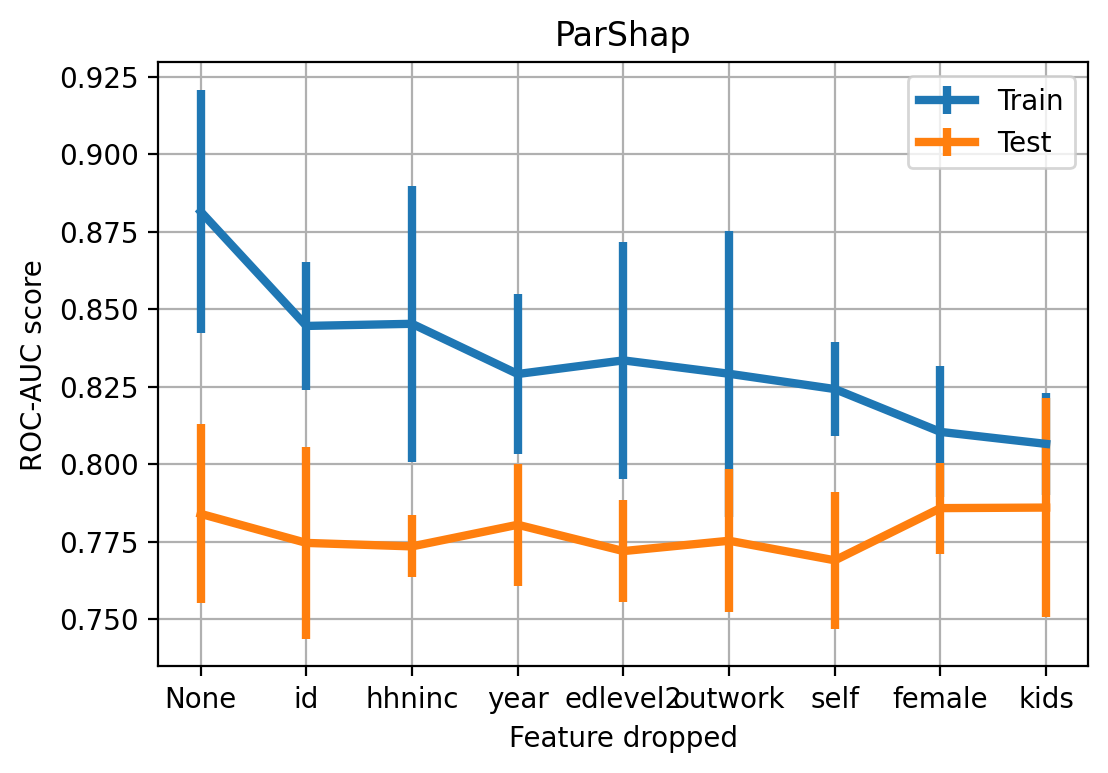

In [449]:
# Plot feature selection
fig, ax = plt.subplots(dpi=200)
plt.subplots_adjust(wspace = .1)

ax.errorbar(
    x=roc_auc_scores['train'].index, 
    y=roc_auc_scores['train'].mean(axis = 1), 
    yerr=roc_auc_scores['train'].max(1) - roc_auc_scores['train'].min(1),
    lw = 3, 
    label = 'Train'
    )

ax.errorbar(
    x=roc_auc_scores['test'].index, 
    y=roc_auc_scores['test'].mean(axis = 1), 
    yerr=roc_auc_scores['test'].max(1) - roc_auc_scores['test'].min(1),
    lw = 3, 
    label = 'Test'
    )

ax.set(
    title='ParShap',
    xlabel='Feature dropped',
    ylabel='ROC-AUC score',
    xticks=roc_auc_scores['train'].index,
    xticklabels=['None'] + features_drop,
)

ax.grid(True)
ax.legend(loc='upper right')

fig.show()